Community 1: ['N0', 'N1', 'N2']
Community 2: ['N10', 'N100', 'N11', 'N12', 'N13', 'N14', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N3', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N39', 'N4', 'N40', 'N41', 'N42', 'N43', 'N45', 'N46', 'N47', 'N48', 'N49', 'N5', 'N50', 'N51', 'N52', 'N54', 'N55', 'N59', 'N6', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67', 'N68', 'N69', 'N7', 'N70', 'N71', 'N72', 'N75', 'N76', 'N77', 'N78', 'N79', 'N8', 'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N9', 'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'N96', 'N97', 'N98', 'N99']
Community 3: ['N16', 'N17']
Community 4: ['N56', 'N57']
Community 5: ['N73', 'N74']


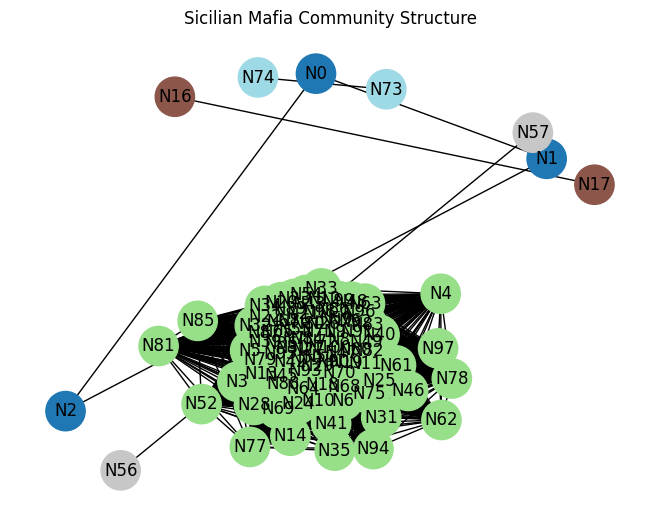

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv("Meetings.csv", sep=r"\s+", header=None)
df.columns = ["u", "v", "w"]

G = nx.Graph()

for _, r in df.iterrows():
    G.add_edge(r["u"], r["v"], weight=r["w"])

for u, v, score in nx.adamic_adar_index(G):
    if score > 0:
        if G.has_edge(u, v):
            G[u][v]["weight"] += score
        else:
            G.add_edge(u, v, weight=score)

for u, v, score in nx.resource_allocation_index(G):
    if score > 0:
        if G.has_edge(u, v):
            G[u][v]["weight"] += score
        else:
            G.add_edge(u, v, weight=score)

from networkx.algorithms.community import asyn_lpa_communities
communities = list(asyn_lpa_communities(G, weight="weight", seed=42))

for i, c in enumerate(communities):
    print(f"Community {i+1}:", sorted(c))

color_map = {}
for i, c in enumerate(communities):
    for n in c:
        color_map[n] = i

node_colors = [color_map.get(n, -1) for n in G.nodes()]

pos = nx.spring_layout(G, seed=42, k=2.5, iterations=100)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,
    node_size=800,
    cmap=plt.cm.tab20
)

plt.title("Sicilian Mafia Community Structure")
plt.show()


Degree of districts:
   District  Degree
4        D4     630
0        B3     626
6       C11     624
8        C6     623
9       D14     623
5        B2     620
3        A1     613
2        E5     612
7       E13     610
10       A7     605
1       E18     603
11      A15     595

Selected key nodes: ['D4', 'B3', 'C11']

Communities around key node D4:
  Community 1: ['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13', 'E18', 'E5']


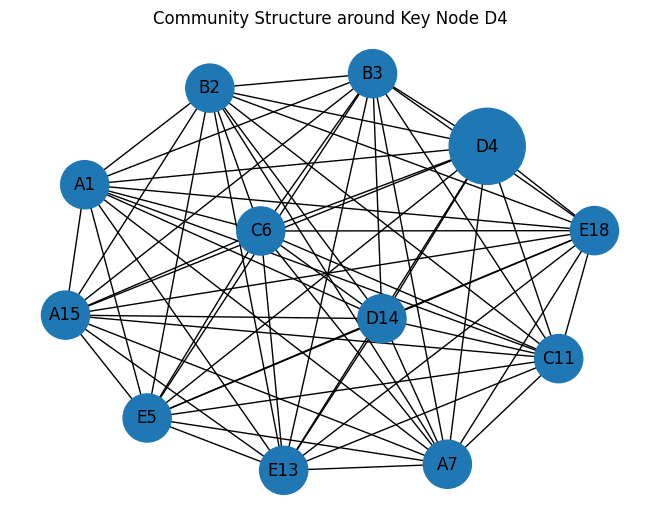


Communities around key node B3:
  Community 1: ['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13', 'E18', 'E5']


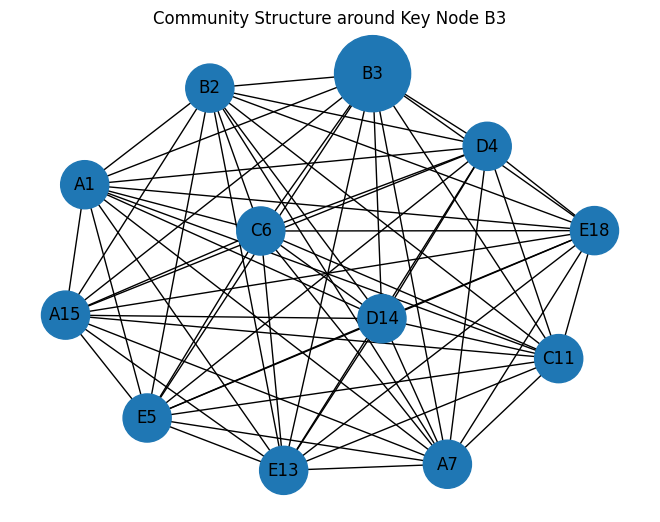


Communities around key node C11:
  Community 1: ['A1', 'A15', 'A7', 'B2', 'B3', 'C11', 'C6', 'D14', 'D4', 'E13', 'E18', 'E5']


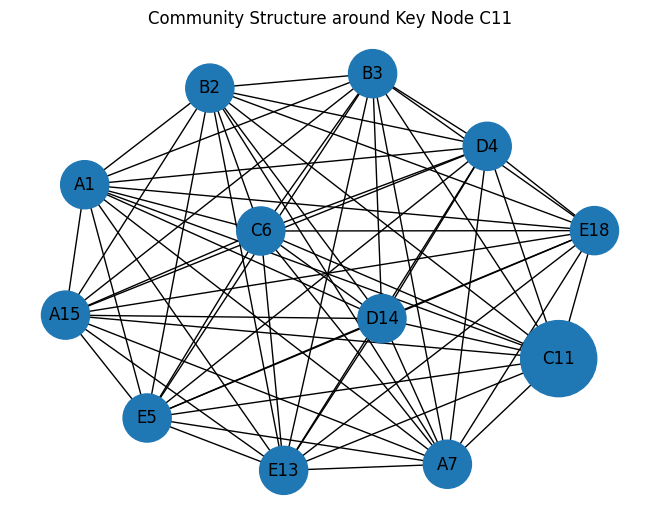

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df = pd.read_csv("boston.csv", low_memory=False)
df = df.dropna(subset=["DISTRICT", "OFFENSE_CODE_GROUP"])

district_crime = df[["DISTRICT", "OFFENSE_CODE_GROUP"]]

B = nx.Graph()
for _, r in district_crime.iterrows():
    B.add_edge(r["DISTRICT"], r["OFFENSE_CODE_GROUP"])

districts = district_crime["DISTRICT"].unique()
G = nx.bipartite.weighted_projected_graph(B, districts)

degree = dict(G.degree(weight="weight"))
degree_df = pd.DataFrame(degree.items(), columns=["District", "Degree"])
degree_df = degree_df.sort_values(by="Degree", ascending=False)

print("Degree of districts:")
print(degree_df)

top_nodes = degree_df.head(3)["District"].tolist()
print("\nSelected key nodes:", top_nodes)

from networkx.algorithms.community import asyn_lpa_communities

for key in top_nodes:
    ego = nx.ego_graph(G, key, radius=1)

    communities = list(asyn_lpa_communities(ego, weight="weight", seed=42))

    print(f"\nCommunities around key node {key}:")
    for i, c in enumerate(communities):
        print(f"  Community {i+1}:", sorted(c))

    pos = nx.spring_layout(ego, seed=42, k=2.5)

    color_map = {}
    for i, c in enumerate(communities):
        for n in c:
            color_map[n] = i

    node_colors = [color_map.get(n, -1) for n in ego.nodes()]
    node_sizes = [3000 if n == key else 1200 for n in ego.nodes()]

    nx.draw(
        ego,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.tab10
    )

    plt.title(f"Community Structure around Key Node {key}")
    plt.show()


In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations
from geopy.distance import geodesic

df = pd.read_csv("boston.csv")
df = df.dropna(subset=["Lat", "Long", "OFFENSE_CODE_GROUP", "OCCURRED_ON_DATE"])
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"])

df = df.sample(400)

G = nx.Graph()

for i, j in combinations(df.index, 2):
    r1, r2 = df.loc[i], df.loc[j]

    if r1["OFFENSE_CODE_GROUP"] != r2["OFFENSE_CODE_GROUP"]:
        continue

    dist = geodesic((r1["Lat"], r1["Long"]), (r2["Lat"], r2["Long"])).meters
    days = abs((r1["OCCURRED_ON_DATE"] - r2["OCCURRED_ON_DATE"]).days)

    if dist <= 2000 and days <= 14:
        G.add_edge(i, j)

from networkx.algorithms.community import asyn_lpa_communities
communities = list(asyn_lpa_communities(G, seed=42))

print("Detected communities:", len(communities))

C:\Users\ariha\AppData\Local\Temp\ipykernel_15100\186354656.py:6: DtypeWarning: Columns (1,3,7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("boston.csv")


Detected communities: 23


In [36]:
ndf = pd.read_csv("boston.csv")
for i in communities:
    print(i)

C:\Users\ariha\AppData\Local\Temp\ipykernel_15100\3246044105.py:1: DtypeWarning: Columns (1,3,7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ndf = pd.read_csv("boston.csv")


{306426, 306493}
{326528, 321453}
{321481, 323031}
{266913, 268002}
{251667, 248707}
{381157, 380845}
{276344, 276902}
{395230, 397998}
{300636, 299893}
{407123, 410103}
{354540, 356183}
{346248, 349591}
{360273, 383901}
{282307, 283493}
{348356, 347077}
{400990, 403567}
{442995, 444743}
{258138, 258159}
{297199, 293623}
{319522, 318276}
{252587, 252318}
{309612, 306373}
{287225, 291529}


{306426: 0, 306493: 0, 326528: 1, 321453: 1, 321481: 2, 323031: 2, 266913: 3, 268002: 3, 251667: 4, 248707: 4, 381157: 5, 380845: 5, 276344: 6, 276902: 6, 395230: 7, 397998: 7, 300636: 8, 299893: 8, 407123: 9, 410103: 9, 354540: 10, 356183: 10, 346248: 11, 349591: 11, 360273: 12, 383901: 12, 282307: 13, 283493: 13, 348356: 14, 347077: 14, 400990: 15, 403567: 15, 442995: 16, 444743: 16, 258138: 17, 258159: 17, 297199: 18, 293623: 18, 319522: 19, 318276: 19, 252587: 20, 252318: 20, 309612: 21, 306373: 21, 287225: 22, 291529: 22}


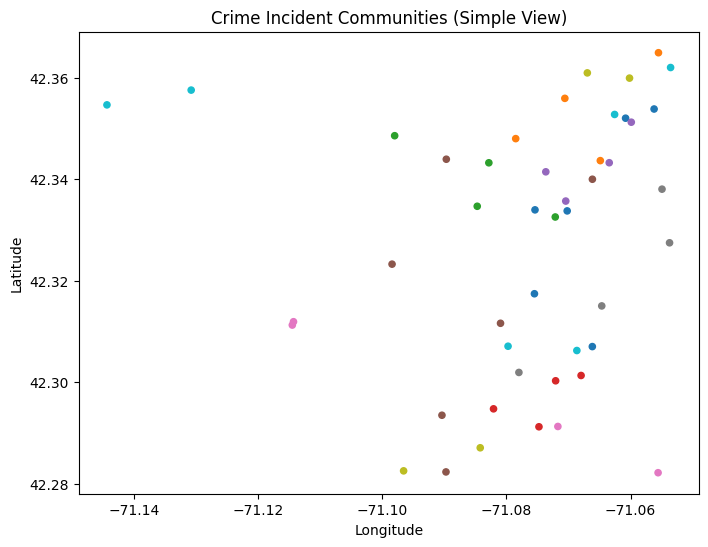

In [32]:
import matplotlib.pyplot as plt

community_map = {}
for i, c in enumerate(communities):
    for n in c:
        community_map[n] = i

print(community_map)

df_plot = df.loc[list(community_map.keys())]
df_plot["community"] = df_plot.index.map(community_map)

plt.figure(figsize=(8, 6))
plt.scatter(
    df_plot["Long"],
    df_plot["Lat"],
    c=df_plot["community"],
    cmap="tab10",
    s=20
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Crime Incident Communities (Simple View)")
plt.show()
